## Book analysis.

The following notebook will presents simple models predicting book sales (unit sold)
based on the following features: genre, publisher_name, publisher_type, average_rating, sales_rank, sale_price and
total_reviews. 

We will use the cleaned dataset book_sales.csv

#### Dependencies

In [4]:
import numpy as np
import pandas as pd

from sklearn.linear_model import RidgeCV, Ridge, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, RocCurveDisplay
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline
# plt.style.use('seaborn-white')

In [6]:
# load data
data_path = 'D://PycharmProjects//springboard//data//'
df = pd.read_csv(f'{data_path}book_sales.csv', index_col=[0])

,genre,sold_by,daily_average_units_sold,publisher_name,publisher_type,average_rating,sale_price,total_reviews,price_range
0,genre fiction,HarperCollins Publishers,7000,Katherine Tegen Books,big five,4.57,4.88,9604,normal
1,genre fiction,HarperCollins Publishers,6250,HarperCollins e-books,big five,4.47,1.99,450,cheap
2,genre fiction,"Amazon Digital Services, Inc.",5500,(Small or Medium Publisher),small/medium,4.16,8.69,30,normal
3,fiction,Hachette Book Group,5500,"Little, Brown and Company",big five,3.84,7.50,3747,normal
4,genre fiction,Penguin Group (USA) LLC,4750,Dutton Children's,big five,4.75,7.99,9174,normal
...,...,...,...,...,...,...,...,...,...
27022,nonfiction,"Amazon Digital Services, Inc.",1,(Small or Medium Publisher),small/medium,4.37,13.99,8,high
27023,nonfiction,"Amazon Digital Services, Inc.",1,(Single-Author Publisher),single author,4.74,9.99,35,normal
27024,nonfiction,"Amazon Digital Services, Inc.",1,(Indie Publisher),indie,0.00,0.99,0,cheap
27025,genre fiction,"Amazon Digital Services, Inc.",1,(Small or Medium Publisher),small/medium,4.71,3.79,7,normal


Transform categorical variables: genre, sold_by, and publisher_type into 1-k 
discrete numbers since these includes only a few different values

In [7]:
reference_dict = dict()

# save genre, sold_by and publisher_type for reference later
# Recode into numeric
for var in ['genre', 'sold_by', 'publisher_type']:
    reference_dict[var] = df[var]
    df[var] = df[var].astype('category').cat.codes

Lets take a look at the correlation between all variables.

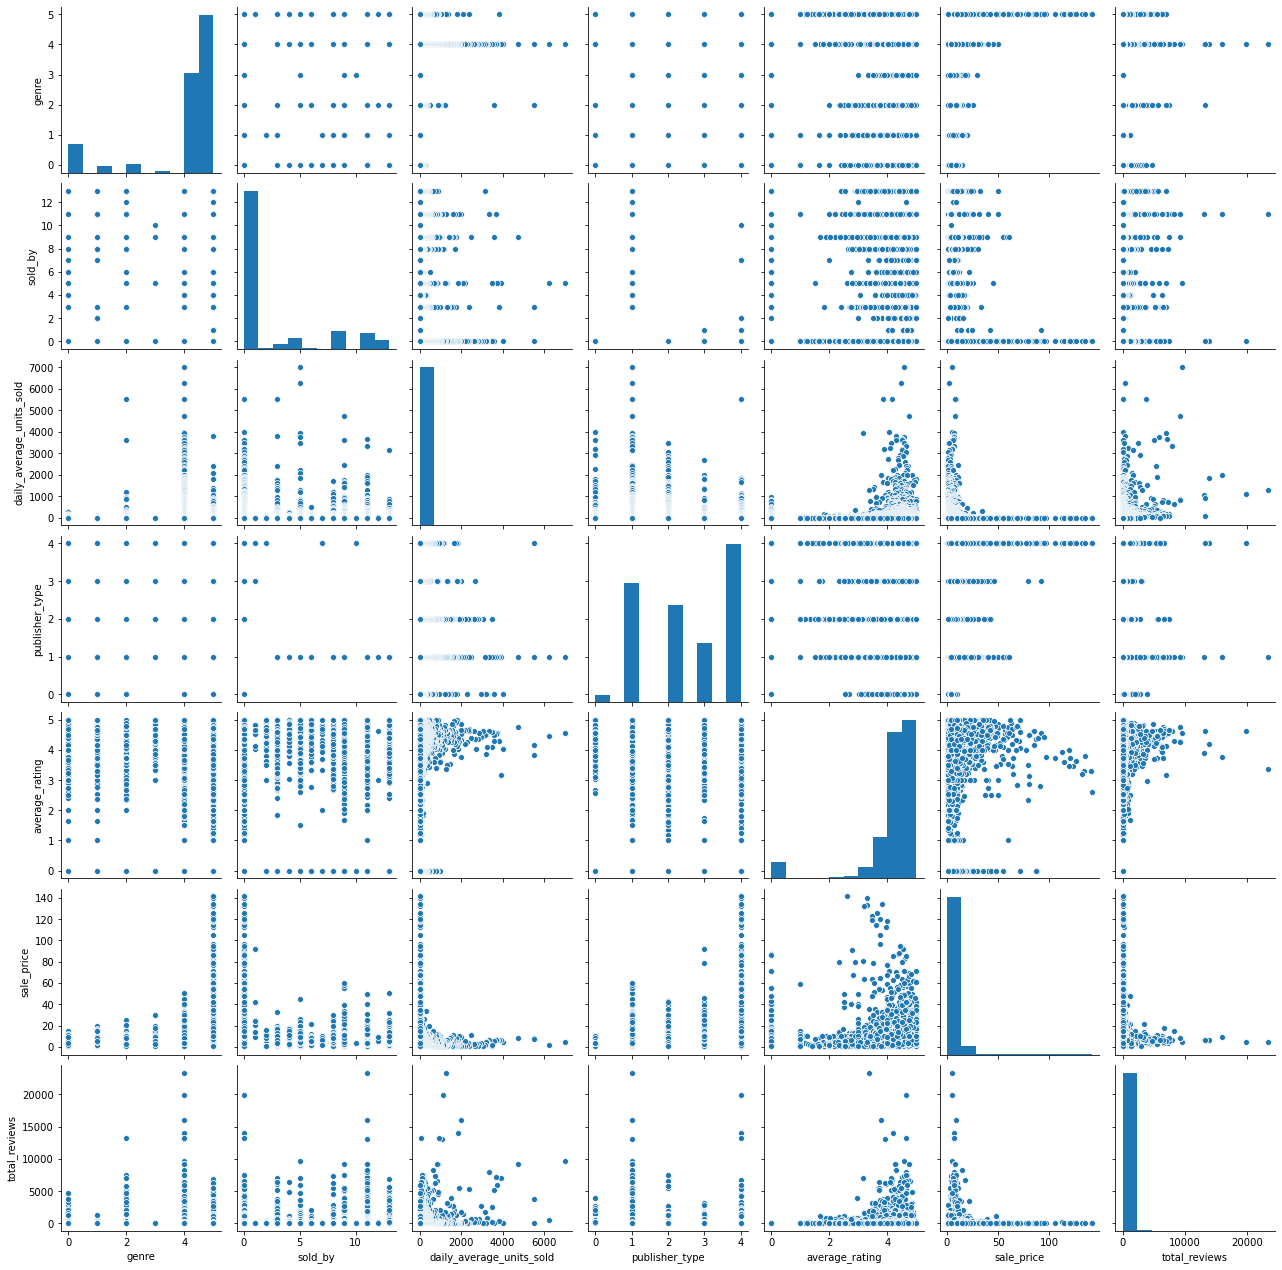

In [12]:
sns.pairplot(df)

Next, we will use the hashing trick to transform publisher_name into 10 variables.

In [13]:
# set feature hashing parameters
fh = FeatureHasher(n_features=10, input_type='string')

# get hashed features array
hashed_features = fh.fit_transform(df['publisher_name']).toarray()

# added hashed_features into df
df = pd.concat([df, pd.DataFrame(hashed_features)], axis=1)

# drop publisher_name columns
df = df.drop('publisher_name', axis=1)
df.head()

,genre,sold_by,daily_average_units_sold,publisher_type,average_rating,sale_price,total_reviews,price_range,0,1,2,3,4,5,6,7,8,9
0,4,5,7000,1,4.57,4.88,9604,normal,0.0,-3.0,0.0,2.0,-2.0,0.0,0.0,0.0,0.0,2.0
1,4,5,6250,1,4.47,1.99,450,cheap,1.0,-4.0,3.0,3.0,-1.0,2.0,-1.0,0.0,0.0,0.0
2,4,0,5500,4,4.16,8.69,30,normal,2.0,-3.0,8.0,1.0,0.0,1.0,2.0,-1.0,-1.0,2.0
3,2,3,5500,1,3.84,7.50,3747,normal,2.0,-5.0,3.0,2.0,-2.0,1.0,0.0,0.0,0.0,0.0
4,4,9,4750,1,4.75,7.99,9174,normal,0.0,-2.0,3.0,1.0,-2.0,0.0,1.0,0.0,-1.0,-1.0


In [14]:
# get X and y
X = df.drop(['daily_average_units_sold','price_range'], axis=1)
y = df.daily_average_units_sold

# scale X for Ridge/Lasso regression
X_scaled = scale(X)

# set up KFold parameters.
kf = KFold(n_splits=5, shuffle=True, random_state=1)

First, lets compare the two linear method: Ridge and Lasso. Setting up model selection
loop as below allowing for flexible reuse afterward. 

Note: the refit=True in GridsearchCV refit the model on the whole data each time. Thus,
there is no need to refit the whole model again.

Note: alphas is changed to 50 instead of 100 to speed up the train time. However, the 
mse barely improve with 100 alphas so it is a good trade off.

In [15]:
# Set up alphas range from small to very large
alphas = 10**np.linspace(10,-2,50)*0.5

# dictionary mapping model and hyper-parameter
models_and_parameters = {'ridge': (Ridge(), {'alpha': alphas}),
                         'lasso': (Lasso(), {'alpha': alphas})}

# collect average score of 5 outer folds
average_mse = dict()

# find the best model with lowest mse
for name, (model, params) in models_and_parameters.items():
    # searches for the best hyper-parameter using inner folds
    regression = GridSearchCV(estimator=model, param_grid=params, 
                             cv=3, scoring='neg_mean_squared_error')

    # estimate mse on 5 folds of data
    scores_across_outer_folds = -1*cross_val_score(regression, X_scaled, y,
                                                   cv=kf, scoring='neg_mean_squared_error')

    # get the mean MSE across each of outer 5 folds
    average_mse[name] = np.mean(scores_across_outer_folds)
    
    # Print error summary 
    error_summary = 'Model: {name}' \
                    '\nMSE in the 5 outer folds: {scores}.' \
                    '\nAverage error: {avg}'
    print(error_summary.format(
        name=name, scores=scores_across_outer_folds,
        avg=np.mean(scores_across_outer_folds)))
    print()

Model: ridge
MSE in the 5 outer folds: [29297.27569442 25383.32539049 16599.2104214  21756.57987966
 16755.60324366].
Average error: 21958.398925926987

Model: lasso
MSE in the 5 outer folds: [29296.66853649 25383.6667366  16598.95703369 21756.68544776
 16755.69196162].
Average error: 21958.333943232203



Unsurprisingly, both methods gives very similar result with Ridge performs insignificantly
better. Refitting the whole data to get the coef. 

### Ridge Regression. 

In [16]:
# Fit ridge regression with RidgeCV alphas
ridgecv = RidgeCV(alphas=alphas).fit(X_scaled,y)
ridge = Ridge(alpha=ridgecv.alpha_).fit(X_scaled,y)

# None of the coefficients are reduced to 0 but very to closed to it.
pd.Series(ridge.coef_, index=X.columns)

genre              0.773262
sold_by          -17.106463
publisher_type   -31.967857
average_rating    -0.161827
sale_price        -6.352419
total_reviews     51.564657
0                  4.694852
1                 -1.055491
2                  7.328286
3                 -1.200524
4                  0.096190
5                 -5.693707
6                  4.944488
7                  3.908603
8                 -4.029254
9                  1.735350
dtype: float64

Some interesting results.
1. genre has a much smaller effect than expected. 
2. Large negative on sold_by/publisher_type indicates that big publishers generally
have better sales. This is expected since they have more resources from quality control
to advertisement.
3. Average rating is negatively correlated with unit_sold. This needs to be studied more
with plots since higher rating should return higher sales.
4. On average, an increase of $1 will decrease sales by 6.35 units.
5. total reviews has a massive impact on book sales. In fact, the number of review is 
more important than the rating on the book. Would this be reverse causality?

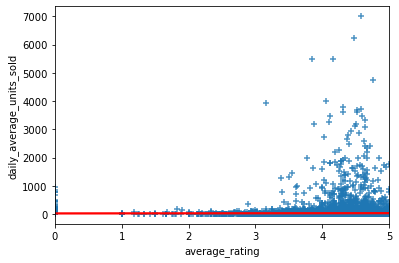

In [17]:
# Explore the rating vs unit_sold
sns.regplot(x='average_rating', y='daily_average_units_sold', data=df, 
            line_kws={'color':'red'}, marker='+', ci=True)

Negative coefficient on average rating seems to be 2 fold:
1. Many 0 score rating pulling its down
2. This is not a linear relationship. 

By revisit the pairplot above, the model can be improved by including 
(average_rating)^2 and log unit_price

### Boosting and RandomForest

Trees methods. max_features is set to default auto. n_estimators = 100.

In [18]:
# Set up alphas range from small to very large
max_depth = [2,5,10,100,200,500]

# dictionary mapping model and hyper-parameter
models_and_parameters = {
    'random_forest': (RandomForestRegressor(), {'max_depth': max_depth}),
    'boosting': (GradientBoostingRegressor(), {'max_depth': max_depth})}

# collect average score of 5 outer folds
average_mse = dict()

# find the best model with lowest mse
for name, (model, params) in models_and_parameters.items():
    # searches for the best hyper-parameter using inner folds
    regression = GridSearchCV(estimator=model, param_grid=params, 
                              cv=3, scoring='neg_mean_squared_error')

    # estimate mse on 5 folds of data
    scores_across_outer_folds = -1*cross_val_score(regression, X, y, cv=kf, 
                                                scoring='neg_mean_squared_error')

    # get the mean MSE across each of outer 5 folds
    average_mse[name] = np.mean(scores_across_outer_folds)
    
    # Print error summary 
    error_summary = 'Model: {name}' \
                    '\nMSE in the 5 outer folds: {scores}.' \
                    '\nAverage error: {avg}'
    print(error_summary.format(
        name=name, scores=scores_across_outer_folds,
        avg=np.mean(scores_across_outer_folds)))
    print()

Model: random_forest
MSE in the 5 outer folds: [26169.94174933 23534.99116768 19483.84376491 21959.92620927
 16176.04700476].
Average error: 21464.949979189616

Model: boosting
MSE in the 5 outer folds: [27109.56543956 23243.95583861 18892.18729334 21606.28749528
 16341.85183822].
Average error: 21438.769581003555



There is a small improvement in MSE but the train time also increase
significantly.

### Random Forest

In [19]:
# Set up train test set
X_test, X_train, y_test, y_train = train_test_split(X,y,test_size=0.2,random_state=1)

# Set up parameters
max_depth = [2,5,10,100,200,500]
parameters = {'max_depth':max_depth}
rf = RandomForestRegressor()

# Fit random forest using GridsearchCV
regression_cv = GridSearchCV(estimator=rf, param_grid=parameters,
                          cv=5, scoring='neg_mean_squared_error')
regression_cv.fit(X_train, y_train)

# Best hyper parameters
print(regression_cv.best_params_)

{'max_depth': 5}


Now we use the best hyper parameter on training data to get the test MSE

In [21]:
# Refit with hyper params on training data
rf = RandomForestRegressor(max_depth=5)
rf.fit(X_test, y_test)
y_pred = rf.predict(X_test)

# print MSE
print('The test MSE of random forest model is:', mean_squared_error(y_test, y_pred))

The test MSE of random forest model is: 14288.048882018886


Last refit using the whole dataset to get the feature Importance

In [22]:
# Refit on whole data
rf = RandomForestRegressor(max_depth=5)
rf.fit(X,y)

# Feature Importance
pd.Series(rf.feature_importances_, index=X.columns)

genre             0.046709
sold_by           0.015321
publisher_type    0.008728
average_rating    0.048635
sale_price        0.062769
total_reviews     0.528626
0                 0.020690
1                 0.046067
2                 0.015812
3                 0.026295
4                 0.120756
5                 0.031050
6                 0.004612
7                 0.004647
8                 0.008477
9                 0.010806
dtype: float64

Feature importance shows the same intuition as our ridge regression above.

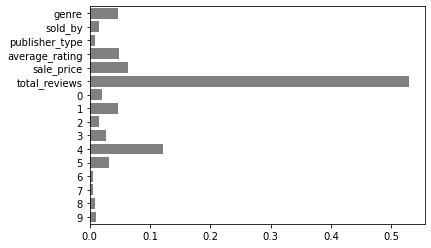

In [52]:
sns.barplot(y=X.columns, x=rf.feature_importances_, color='grey')